# Text Ranking

In [35]:
import csv
import math
import matplotlib.pyplot as plt
from nltk import word_tokenize
import numpy as np
import przona
import random
import re
import sys
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
CSV_DIR = "csv/"

paragraphs = przona.read_dict(CSV_DIR+"paragraphs.csv")

In [3]:
def get_url_suffixes(paragraphs):
    suffixes = {}
    for url in paragraphs.keys():
        if re.search("^/richtlijn", url):
            suffix = "."+url.split(".")[-1].split("?")[0]
            if re.search("/", suffix): suffix = "(folder)"
            if suffix in suffixes: suffixes[suffix] += 1
            else: suffixes[suffix] = 1
    return(suffixes)

get_url_suffixes(paragraphs)

{'.html': 8750, '(folder)': 420, '.php': 153}

All the files in the folder `/richtlijn` seem to be HTML files. The `.php` files might be an exception but they cannot be retrieved. The other two file types are HTML files (`.html`) and folders.

## Keywords

In [4]:
KEYWORDS_FILE = "../data/210119 Digitale zorg - sleutelwoorden en combinaties.csv"
KEYWORDS_FILE_V2 = "../data/210119 Digitale zorg - sleutelwoorden en combinaties v2.csv"

In [5]:
def get_keywords(keywords_file):
    infile = open(keywords_file, "r")
    csvreader = csv.reader(infile)
    keywords = []
    for row in csvreader:
        if row[1].strip() == "ja":
            keywords.append(row[0].strip())
        elif row[1].strip() == "nee":
            for i in range(2, len(row)):
                if row[i].strip() != "":
                    keywords.append(row[i].strip())
    infile.close()
    return(keywords)

len(get_keywords(KEYWORDS_FILE))

111

In [6]:
def get_keywords_v2(keywords_file):
    infile = open(keywords_file, "r")
    csvreader = csv.reader(infile)
    keywords = {}
    for row in csvreader:
        if row[0].strip() != "Term":
            keywords[row[0].strip()] = row[1].strip
    infile.close()
    return(keywords)

len(get_keywords_v2(KEYWORDS_FILE_V2))

111

In [7]:
sorted(get_keywords(KEYWORDS_FILE)) == sorted(list(get_keywords_v2(KEYWORDS_FILE_V2).keys()))

True

## Keyword expansion

Allow keywords with spaces, like `digital care`,to be spelled without the space or with a hyphen: `digitalcare` and `digital-care`.

In [8]:
def make_new_keywords(prefix, suffix_list):
    if len(suffix_list) > 1:
        suffix_list = make_new_keywords(suffix_list[0], suffix_list[1:])
    new_keywords = []
    for suffix in suffix_list:
        new_keywords.append(prefix+suffix)
        new_keywords.append(prefix+" "+suffix)
        new_keywords.append(prefix+"-"+suffix)
    return(new_keywords)

def expand_keywords(keywords):
    keywords.extend(["e health", "e health toepassing", "e learning", "tele begeleiding", "tele consultatie", "tele health", "tele medicine", "tele monitoring"])
    for i in range(0,len(keywords)):
        keywords[i] = keywords[i].strip().lower()
    new_keywords = []
    for keyword in keywords:
        keyword_parts = keyword.split()
        if len(keyword_parts) > 1:
            for new_keyword in make_new_keywords(keyword_parts[0], keyword_parts[1:]):
                if new_keyword not in keywords and new_keyword not in new_keywords:
                    new_keywords.append(new_keyword)
    keywords.extend(new_keywords)
    return(sorted(list(set(keywords))))

## Finding paragraphs with keywords

In [9]:
keywords = expand_keywords(get_keywords(KEYWORDS_FILE))

In [10]:
len(keywords)

330

In [11]:
def count_words(text):
    return(len(text.strip().split()))

In [29]:
MIN_NBR_OF_WORDS = 10

def find_matching_paragraphs(keywords, paragraphs):
    matching_urls = {}
    matching_paragraphs = []
    non_matching_paragraphs = []
    counter = 0
    for url in paragraphs:
        for paragraph in paragraphs[url]:
            if count_words(paragraph) >= MIN_NBR_OF_WORDS:
                match = ""
                for keyword in keywords:
                    if keyword in ["app", "apps"]:
                        keyword = r'\b'+keyword+r'\b'
                    if re.search("^e ", keyword):
                        keyword = r'\b'+keyword
                    for dummy in re.findall(keyword, paragraph, flags=re.IGNORECASE):
                        if match == "":
                            match = keyword
                        else:
                            match += "#"+keyword
                        if url in matching_urls:
                            matching_urls[url] += "#"+keyword
                        else:
                            matching_urls[url] = keyword
                if match != "":
                    matching_paragraphs.append([match, paragraph])
                else:
                    non_matching_paragraphs.append(paragraph)
        counter += 1
        przona.squeal(f"documents: {counter}; matches: {len(matching_paragraphs)}")
    return(matching_paragraphs, non_matching_paragraphs, matching_urls)

matching_paragraphs, non_matching_paragraphs, matching_urls = \
    find_matching_paragraphs(keywords, { url:paragraphs[url] for url in paragraphs.keys() if re.search("^/richtlijn", url) })

documents: 9323; matches: 1115


In [33]:
recommendations = {}
for url in matching_urls:
    recommendation = url.split("/")[2]
    if recommendation in recommendations:
        recommendations[recommendation] += "#"+matching_urls[url]
    else:
        recommendations[recommendation] = matching_urls[url]

In [34]:
len(matching_paragraphs), len(non_matching_paragraphs), len(matching_urls), len(recommendations)

(1115, 1067872, 717, 101)

Without keyword expansion (111 keywords), we found 1,088 matching paragraphs and 1,067,899 non-matching paragraphs.
With keyword expansion (330 keywords), we found 1,115 matching paragraphs and 1,067,872 non-matching paragraphs.

In [14]:
keywords_found = {}
for kws,p in matching_paragraphs:
    for k in kws.split("#"):
        if k in keywords_found:
            keywords_found[k] += 1
        else:
            keywords_found[k] = 1
print(len(keywords_found), {k:keywords_found[k] for k in sorted(keywords_found.keys(), key=lambda k:keywords_found[k], reverse=True)})

37 {'e-learning': 278, '\\bapp\\b': 253, 'e-health': 217, 'ehealth': 119, 'telemedicine': 59, '\\bapps\\b': 51, 'e-health toepassing': 42, 'digitale vragenlijst': 39, 'online vragenlijst': 35, '\\be health': 17, 'telehealth': 13, 'ehealth toepassing': 13, 'telemonitoring': 11, 'teleconsultatie': 10, 'online ondersteuning': 10, 'online monitoring': 9, 'domotica': 6, 'blended care': 6, 'online contact': 6, 'internetbehandeling': 4, 'elearning': 3, 'digitale ondersteuning': 3, 'digitale zorg': 3, 'blendedcare': 2, 'digitale monitoring': 2, 'e-health-toepassing': 2, 'geautomatiseerde ondersteuning': 2, 'internetmodule': 2, 'geautomatiseerde monitoring': 1, 'online behandeling': 1, 'tele-consultatie': 1, 'internet module': 1, 'online voorlichting': 1, 'online screening': 1, 'online module': 1, 'digitale screening': 1, 'internet vragenlijst': 1}


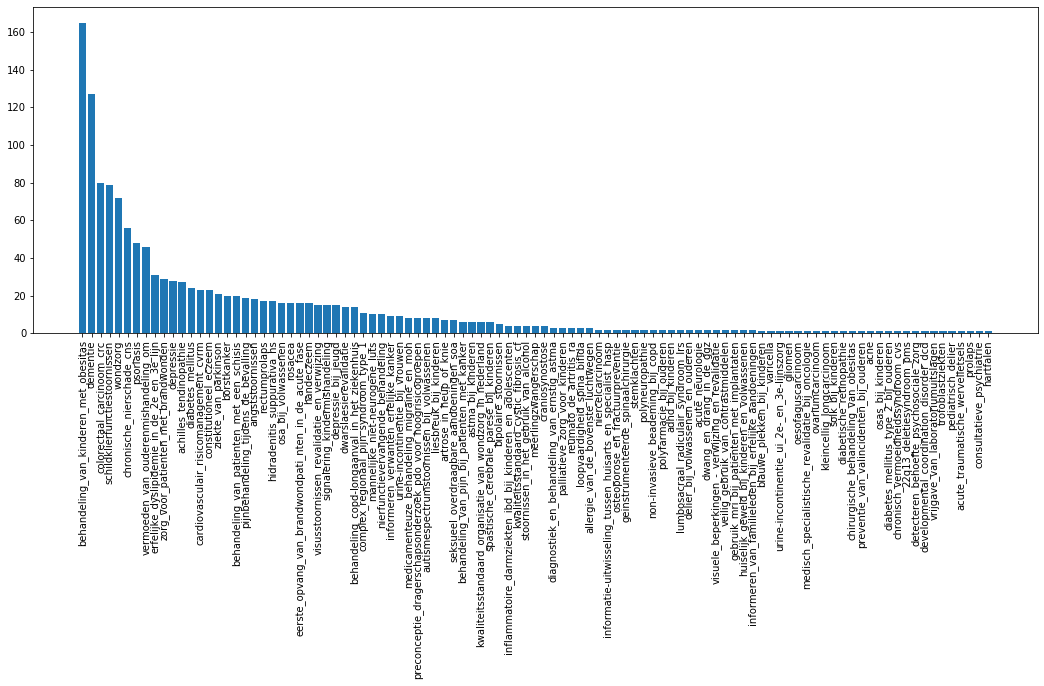

In [79]:
recommendations = {r:recommendations[r] for r in sorted(recommendations.keys(), key=lambda r:len(recommendations[r].split("#")), reverse=True)}

plt.subplots(figsize=(18,6))
plt.bar(list(recommendations.keys()), [len(recommendations[r].split('#')) for r in recommendations])
plt.xticks(rotation=90)
plt.savefig("plot.png")
plt.show()

## Comparing vocabularies

In [15]:
def count_tokens(text):
    tokens, frequencies = np.unique(word_tokenize(text), return_counts=True)
    return({tokens[i]:frequencies[i] for i in range(0, len(tokens))})

In [16]:
def ran_select(large_list, selection_size):
    if selection_size >= len(large_list):
        return(large_list)
    selected_list = []
    seen = {}
    while len(selected_list) < selection_size:
        selected_id = random.randint(0, len(large_list)-1)
        if not selected_id in seen:
            selected_list.append(large_list[selected_id])
            seen[selected_id] = True
    return(selected_list)

In [17]:
matching_tokens = count_tokens((" ".join([pair[1] for pair in matching_paragraphs])).lower())

Creating the vocabulary of the one-million non-matching paragraphs fails because of memory problems. Using a random sample worked for at most 85,000 paragraphs but allways. Perhaps changing the `count_tokens` function could solve this problem.  

In [18]:
non_matching_tokens = count_tokens((" ".join(ran_select(non_matching_paragraphs, 85000))).lower())

In [19]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

In [43]:
tscores_data_matching = makeTscoreData(matching_tokens)
tscores_data_non_matching = makeTscoreData(non_matching_tokens)
context_words = dictTopN(sortTscores(tscore.computeTscore(tscores_data_matching, tscores_data_non_matching)), n=500)
for x in context_words:
    print(x[1], end=" ")

e-learning e-health app lid ehealth ontwikkeld online ' een vorm vragenlijst dementie\ richtlijn afdeling bijscholingsactiviteiten richtlijntoets na- geaccrediteerde –in colorectaal maak carcinoom behoeve interventie roche dementie bruikbaarheid via – kader digitale ontwikkelaar radboudumc telemedicine toepassingen ten module applicatie https nefroloog therapy telenefrologie verwijsgedrag oogartsen huisarts relevant //gdt.gradepro.org/app/handbook/handbook.html zorgverleners 2013. aan consultatie grant zorgdomein grade en hand problem `` solving counseling consortiumlid decisionmaking innoveren mhealth plezierige windesheim zorgnetwerken adviescie nivel/trimbos \'shared lectoraat ouderenzorg evaluatieonderzoek nivel casemanagement onderzoeksgroep zou exercise toegang websites zwolle \ acute activiteiten recommendations intensieve vier ouderenmishandeling kunnen smartphones downloaden psoriasis het bleek implementatie werken 2012-2016 emrp hlt07- metrology praktijktest researcher huisar

## Select best-matching paragraph

In [47]:
context_counts = []
for match,paragraph in matching_paragraphs:
    context_counts.append(0)
    for score, word in context_words:
        for dummy in re.findall(r'\b'+word+r'\b', paragraph):
            context_counts[-1] += 1

In [56]:
sorted_matching_paragraphs_context = [matching_paragraphs[i] 
                              for i in sorted(range(0,len(matching_paragraphs)), key=lambda i:context_counts[i], reverse=True)]
sorted_context_counts = [context_counts[i] 
                              for i in sorted(range(0,len(matching_paragraphs)), key=lambda i:context_counts[i], reverse=True)]

In [76]:
sorted_matching_paragraphs_context[0],sorted_context_counts[0]

(['e-learning#e-learning',
  'In een RCT (Trivalle, 2010) werd het effect van een educatieve interventie op het aantal vermijdbare ADE’s bij ouderen opgenomen in het ziekenhuis. Gedurende één week kregen de behandelteams op de interventie afdelingen onderwijs over het voorschrijven aan oudere patiënten (onder andere hoe om te gaan met risico medicatie zoals antipsychotica, benzodiazepines, NSAIDs, en over dosisaanpassingen bij verminderde nierfunctie), ADE’s incidentie en interventie strategieën. Het aantal ADE’s werd met 14% gereduceerd. In een before-and-after studie van Lutters (2004) werd een onderwijsprogramma bestaande uit distributie van richtlijnen over urineweg en luchtweginfecties en colleges over geriatrische infectieziekten gecombineerd met een wekelijkse audit-en-feedback waarbij voor patiënten met verdenking op infectie gerichte individuele begeleiding bij het stellen van diagnose en kiezen van antibiotica aan de voorschrijver werd geboden. Deze interventie resulteerde in

In [62]:
sorted_matching_paragraphs_keywords = [m for m in sorted(matching_paragraphs, key=lambda m:len(m[0].split("#")), reverse=True)]

In [77]:
sorted_matching_paragraphs_keywords[1]

['digitale ondersteuning#digitale zorg#ehealth#ehealth#ehealth#ehealth#ehealth toepassing',
 'De positieve effecten van beeldschermzorg op de kosten zijn in de gezondheidszorg tot dusverre nog niet overtuigend bewezen. Dit geldt ook voor een GLI behandeling met beeldschermzorg. Het toepassen van eHealth wordt door de overheid gezien als mogelijkheid om de kosten van de gezondheidszorg te verminderen. De kosten van eHealth en mHealth zijn niet eenduidig. EHealth toepassingen bovenop reguliere zorg kan extra kosten met zich meebrengen. Het implementeren van digitale zorg in de werkwijze van zorgverleners kost tijd en geld. Ook is er digitale ondersteuning nodig voor de zorggebruikers qua vaardigheid en middelen. Tenslotte zijn er ontwikkel- en jaarlijkse licentiekosten van de verschillende eHealth-platformleveranciers.']

/richtlijn/behandeling_van_kinderen_met_obesitas/ehealth_mhealth_bij_gli.html